In [1]:
import math

import torch
import tqdm
import torchvision
from matplotlib import pyplot

In [2]:
class ConditionalConvolutionalVAE(torch.nn.Module):
    def __init__(self, input_channels: int = 1, num_classes: int = 10, image_size: int = 28, latent_dimension: int = 32) -> None:
        super().__init__()
        
        self.num_classes = num_classes
        self.image_size = image_size
        self.latent_dimension = latent_dimension

        self.class_embedding = torch.nn.Embedding(num_classes, image_size * image_size)
        
        self.encoder_convolution1 = torch.nn.Conv2d(input_channels + 1, 32, kernel_size=3, stride=2, padding=1)
        self.encoder_convolution2 = torch.nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        
        self.convolved_size = convolved_size(image_size, kernel_size=3, stride=2, padding=1)
        self.flattened_dimension = 64 * self.convolved_size * self.convolved_size
        
        self.mean_linear = torch.nn.Linear(self.flattened_dimension, latent_dimension)
        self.log_variance_linear = torch.nn.Linear(self.flattened_dimension, latent_dimension)

        self.decoder_linear = torch.nn.Linear(latent_dimension + num_classes, self.flattened_dimension)
        self.decoder_convolution1 = torch.nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.decoder_convolution2 = torch.nn.ConvTranspose2d(32, input_channels, kernel_size=3, stride=2, padding=1, output_padding=1)

    def encode(self, x: torch.Tensor, class_label: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        label_embedding = self.class_embedding.forward(class_label).reshape(-1, 1, self.image_size, self.image_size)

        x = torch.cat([x, label_embedding], dim=1)
        x = torch.nn.functional.relu(self.encoder_convolution1.forward(x))
        x = torch.nn.functional.relu(self.encoder_convolution2.forward(x))
        x = x.flatten(1, -1)
        
        mean = self.mean_linear.forward(x)
        log_variance = self.log_variance_linear.forward(x)

        return mean, log_variance

    def reparameterize(self, mean: torch.Tensor, log_variance: torch.Tensor) -> torch.Tensor:
        if not self.training:
            return mean
        
        variance = torch.exp(0.5 * log_variance)
        white_noise = torch.randn_like(variance)
        
        return mean + white_noise * variance
    
    def decode(self, latent_vector: torch.Tensor, class_label: torch.Tensor) -> torch.Tensor:
        class_label_one_hot = torch.nn.functional.one_hot(class_label, num_classes=self.num_classes).float()
        input = torch.cat([latent_vector, class_label_one_hot], dim=1)
        
        x = self.decoder_linear.forward(input)
        x = x.reshape(-1, 64, self.convolved_size, self.convolved_size)
        x = torch.nn.functional.relu(self.decoder_convolution1.forward(x))
        x = torch.sigmoid(self.decoder_convolution2.forward(x))
        
        return x

    def forward(
        self,
        x: torch.Tensor,
        class_label: torch.Tensor,
    ) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        mean, log_variance = self.encode(x, class_label)
        latent_vector = self.reparameterize(mean, log_variance)
        out = self.decode(latent_vector, class_label)
        
        return out, mean, log_variance


def convolved_size(image_size: int, kernel_size: int, stride: int, padding: int) -> int:
    size = int(math.floor((image_size + 2 * padding - kernel_size) / stride + 1))
    size = int(math.floor((size + 2 * padding - kernel_size) / stride + 1))
    return size

In [3]:
def loss_function(
    x: torch.Tensor,
    x_reconstructed: torch.Tensor,
    mean: torch.Tensor,
    log_variance: torch.Tensor,
) -> torch.Tensor:
    mse = torch.nn.functional.mse_loss(
        x_reconstructed,
        x,
        reduction="sum",
    )
    
    kl_divergence = -0.5 * torch.sum(
        1 + log_variance - mean.pow(2) - log_variance.exp()
    )

    return mse + kl_divergence

In [4]:
def train(
    model: ConditionalConvolutionalVAE,
    train_loader: torch.utils.data.DataLoader,
    num_epochs: int,
    learning_rate: float,
    device: torch.device,
) -> None:
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, fused=True)

    for epoch in range(1, num_epochs + 1):
        epoch_loss = 0.0

        for image, class_label in tqdm.tqdm(train_loader, desc="Mini batch"):
            image = image.to(device)
            class_label = class_label.to(device)

            image_reconstructed, mean, log_variance = model.forward(image, class_label)
            
            loss = loss_function(image, image_reconstructed, mean, log_variance)
            loss.backward()
            epoch_loss += loss.cpu().item()

            optimizer.step()
            optimizer.zero_grad()

        epoch_loss_avg = epoch_loss / len(train_loader)
        print(f"Epoch {epoch}: avg. loss: {epoch_loss_avg:.2f}")

In [5]:
dataset = torchvision.datasets.MNIST(
    "./data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
)

In [6]:
BATCH_SIZE = 16
NUM_EPOCHS = 5
LEARNING_RATE = 1e-3

In [7]:
device = (
    torch.device("cuda")
    if torch.cuda.is_available()
    else torch.device("mps")
    if torch.mps.is_available
    else torch.device("cpu")
)

In [8]:
data_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [9]:
model = ConditionalConvolutionalVAE().to(device)

In [10]:
train(model, data_loader, num_epochs=NUM_EPOCHS, learning_rate=LEARNING_RATE, device=device)

Mini batch: 100%|██████████| 3750/3750 [00:16<00:00, 225.60it/s]


Epoch 1: avg. loss: 553.75


Mini batch: 100%|██████████| 3750/3750 [00:16<00:00, 225.96it/s]


Epoch 2: avg. loss: 458.95


Mini batch: 100%|██████████| 3750/3750 [00:16<00:00, 233.38it/s]


Epoch 3: avg. loss: 442.09


Mini batch: 100%|██████████| 3750/3750 [00:14<00:00, 256.30it/s]


Epoch 4: avg. loss: 431.82


Mini batch: 100%|██████████| 3750/3750 [00:15<00:00, 246.80it/s]

Epoch 5: avg. loss: 424.46


In [11]:
@torch.inference_mode()
def generate_digit(model: ConditionalConvolutionalVAE, class_label: int, device: torch.device) -> torch.Tensor:
    latent_vector = torch.randn(1, model.latent_dimension).to(device)
    class_label = torch.tensor(class_label).unsqueeze(0).to(device, torch.long)
    generated_image = model.decode(latent_vector, class_label).squeeze(0)
    return generated_image

In [12]:
@torch.inference_mode()
def visualize_digits_grid(
    model: ConditionalConvolutionalVAE,
    num_samples: int,
    device: torch.device,
) -> None:
    y = torch.arange(0, 10).to(device)
    y = y.repeat(num_samples)
    z = torch.randn(num_samples * 10, model.latent_dimension).to(device)
    generated_images = model.decode(z, y)

    grid = (
        torchvision.utils.make_grid(generated_images, nrow=10, padding=2, pad_value=1.0)
        .cpu()
        .detach()
        .permute(1, 2, 0)
        .numpy()
    )

    pyplot.figure(figsize=(15, num_samples * 1.5))
    pyplot.imshow(grid, cmap="gray")
    pyplot.axis("off")
    pyplot.title(f"Generated Digits Grid ({num_samples} samples per digit)", fontsize=16)
    pyplot.show()

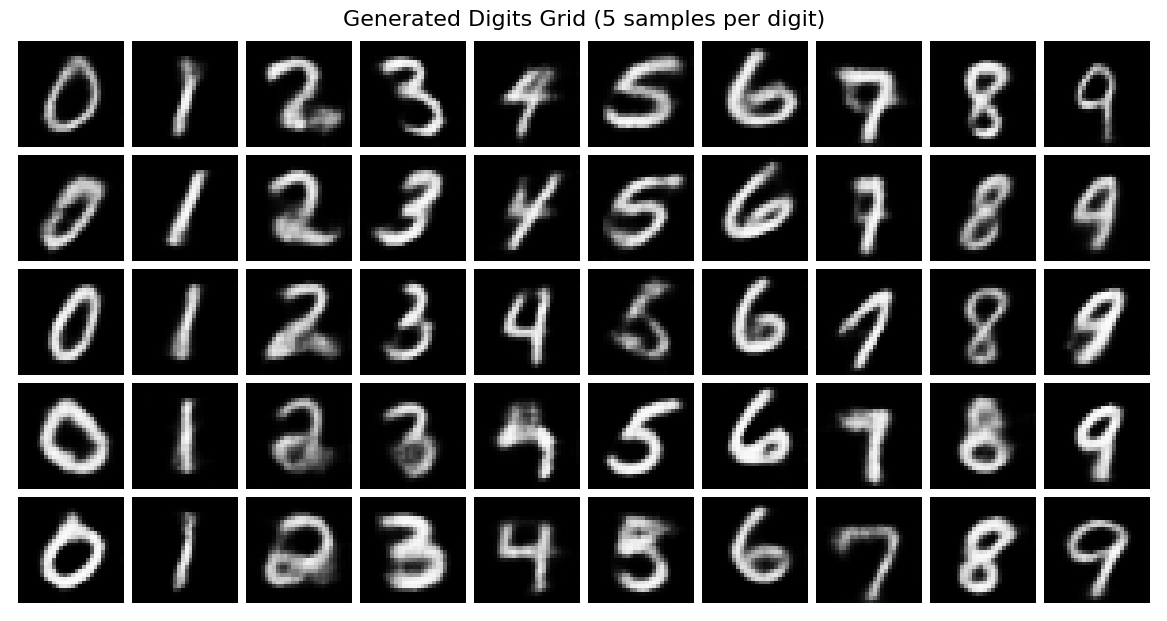

In [13]:
visualize_digits_grid(model, num_samples=5, device=device)